In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import roc_auc_score, f1_score, matthews_corrcoef

import pandas as pd
import numpy as np
import seaborn as sns

from my_util import *
from lime.lime.lime_tabular import LimeTabularExplainer

# from pyexplainer.pyexplainer_pyexplainer import PyExplainer
import matplotlib.pyplot as plt

import os, pickle, time, re, sys
from datetime import datetime
from collections import Counter


sys.path.append(os.path.abspath('../pyexplainer'))
from pyexplainer_pyexplainer import *

from IPython.display import display

In [6]:
data_path = './dataset/'
result_dir = './eval_result/'
dump_dataframe_dir = './dump_df/'
pyExp_dir = './pyExplainer_obj/'
other_object_dir = './other_object/'
# proj_name = 'qt' # ['openstack','qt']

In [7]:
def get_top_k_global_features(global_model, indep, top_k_global_feature_num = 5):
    global_feature_df = pd.DataFrame()
    global_feature_df['feature'] = indep
    global_feature_df['importance'] = global_model.feature_importances_

    global_feature_df = global_feature_df.sort_values(by='importance',ascending=False)

    top_k_global_features = list(global_feature_df['feature'])[:top_k_global_feature_num]

    return top_k_global_features
    
def get_rule_str_of_rulefit(local_rulefit_model):
    rule_df = local_rulefit_model.get_rules()
    top_k = 5
    top_k_positive_rules = rule_df[(rule_df.coef > 0) & (rule_df.type=='rule')].sort_values("importance", ascending=False).head(top_k)

    the_best_defective_rule_str = list(top_k_positive_rules['rule'])[0]
    
    return the_best_defective_rule_str

def aggregate_list(l):
    return np.mean(l), np.median(l)


In [135]:
# '''
#     synthetic_inst1: generated instance used with global model
#     synthetic_inst2: generated instance used with local model
#     global_model, local_model: any sklearn ML model or ML model that is extended from ML model
# '''
# def cal_bal_acc(synthetic_inst1, synthetic_inst2, global_model, local_model):
#     global_pred = global_model.predict(synthetic_inst1)
#     local_pred = local_model.predict(synthetic_inst2)
    
#     # in case prediction of local model is not binary 
#     if set(local_pred) != set([True, False]):
#         local_pred = np.round(local_pred)
#         local_pred = [True if val else False for val in local_pred]
        
#     bal_acc = balanced_accuracy_score(global_pred, local_pred)
#     return bal_acc
    

def is_in_top_k_global_features(top_k_global_features, the_best_defective_rule_str):
    # remove numeric value
    new_the_best_defective_rule_str = re.sub('\d+','', the_best_defective_rule_str)

    # remove special characters
    new_the_best_defective_rule_str = re.sub('\W+',' ',new_the_best_defective_rule_str)
    splitted_rule = new_the_best_defective_rule_str.split()

#     ret = False
    local_feature_count = 0
    
    found_features = set(splitted_rule).intersection(top_k_global_features)
#     for tok in splitted_rule:
#         if tok.strip() in top_k_global_features:
#             found_features.append(tok)
#             ret = True
#             break
#             local_feature_count = local_feature_count+1
#     local_feature_ratio = local_feature_count/len(splitted_rule)
#     return ret
#     return local_feature_ratio
    return list(found_features)

# def eval_rule(rule, X_explain):
#     var_in_rule = re.findall('[a-zA-Z]+',rule)
#     rule = rule.replace('&','and') # just for rulefit
#     rule = re.sub(r'\b=\b','==',rule)
# #             rule = rule.replace('=','==')

#     var_dict = {}

#     for var in var_in_rule:
#         var_dict[var] = float(X_explain[var])

#     eval_result = eval(rule,var_dict)
#     return eval_result

        
def prepare_data_for_testing(proj_name):
    global_model = pickle.load(open(proj_name+'_global_model.pkl','rb'))

    correctly_predict_df = pd.read_csv(dump_dataframe_dir+proj_name+'_correctly_predict_as_defective.csv')
    correctly_predict_df = correctly_predict_df.set_index('commit_id')

    dep = 'defect'
    indep = correctly_predict_df.columns[:-3] # exclude the last 3 columns

    feature_df = correctly_predict_df.loc[:, indep]
    
    return global_model, correctly_predict_df, indep, dep, feature_df
    
def rq1_eval(proj_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
    all_eval_result = pd.DataFrame()
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'.pkl','rb'))
        lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

        # this data can be used for both local and global model
        py_exp_synthetic_data = py_exp['synthetic_data'].values
        # this data can be used with global model only
        lime_exp_synthetic_data = lime_exp['synthetic_instance_for_global_model']
        # this data can be used with local model only
        lime_exp_synthetic_data_local = lime_exp['synthetic_instance_for_lobal_model']
        
        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']

        py_exp_local_pred = py_exp_local_model.predict(py_exp_synthetic_data)
        py_exp_local_pred = [1 if val else 0 for val in py_exp_local_pred]

        lime_exp_global_pred = global_model.predict(lime_exp_synthetic_data)
        lime_exp_local_pred = lime_exp_local_model.predict(lime_exp_synthetic_data_local)
        lime_exp_local_pred = np.round(lime_exp_local_pred)

        py_exp_dist = euclidean_distances(X_explain.values, py_exp_synthetic_data)
        lime_dist = euclidean_distances(X_explain.values, lime_exp_synthetic_data)

        py_exp_dist_mean, py_exp_dist_med = aggregate_list(py_exp_dist)
        lime_exp_dist_mean, lime_exp_dist_med = aggregate_list(lime_dist)

        py_exp_def_pred_ratio = np.sum(py_exp_local_pred)/len(py_exp_local_pred)
        lime_exp_def_pred_ratio = np.sum(lime_exp_local_pred)/len(lime_exp_local_pred)
        
        py_exp_serie = pd.Series(data=[proj_name, row_index, 'crossover_interpolation',
                                       py_exp_dist_med, py_exp_def_pred_ratio])
        lime_exp_serie = pd.Series(data=[proj_name, row_index, 'LIME',
                                         lime_exp_dist_med, lime_exp_def_pred_ratio])
        
        all_eval_result = all_eval_result.append(py_exp_serie,ignore_index=True)
        all_eval_result = all_eval_result.append(lime_exp_serie, ignore_index=True)
        
    all_eval_result.columns =['project', 'commit id', 'method', 'euc_dist_med', 'defective_generated_instance_ratio']
    
#     display(all_eval_result)
    all_eval_result.to_csv(result_dir+'RQ1_'+proj_name+'.csv',index=False)
    print('finished RQ1 of',proj_name)
    
    
def rq2_eval(proj_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
    all_eval_result = pd.DataFrame()
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'.pkl','rb'))
        lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

        # this data can be used for both local and global model
        py_exp_synthetic_data = py_exp['synthetic_data'].values
        # this data can be used with global model only
        lime_exp_synthetic_data = lime_exp['synthetic_instance_for_global_model']
        # this data can be used with local model only
        lime_exp_synthetic_data_local = lime_exp['synthetic_instance_for_lobal_model']
        
        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']

        py_exp_global_pred = global_model.predict(py_exp_synthetic_data) 
        py_exp_local_prob = py_exp_local_model.predict_proba(py_exp_synthetic_data)[:,1]
        py_exp_local_pred = py_exp_local_model.predict(py_exp_synthetic_data)
#         py_exp_local_pred = [1 if val else 0 for val in py_exp_local_pred]

        lime_exp_global_pred = global_model.predict(lime_exp_synthetic_data)
        lime_exp_local_prob = lime_exp_local_model.predict(lime_exp_synthetic_data_local)
        lime_exp_local_pred = np.round(lime_exp_local_prob)
        
        py_exp_auc = roc_auc_score(py_exp_global_pred, py_exp_local_prob)
        py_exp_f1 = f1_score(py_exp_global_pred, py_exp_local_pred)
        py_exp_mcc = matthews_corrcoef(py_exp_global_pred, py_exp_local_pred)
        py_exp_bal_acc = balanced_accuracy_score(py_exp_global_pred, py_exp_local_pred)
        
        lime_auc = roc_auc_score(lime_exp_global_pred, lime_exp_local_prob)
        lime_f1 = f1_score(lime_exp_global_pred, lime_exp_local_pred)
        lime_mcc = matthews_corrcoef(lime_exp_global_pred, lime_exp_local_pred)
        lime_exp_bal_acc = balanced_accuracy_score(lime_exp_global_pred, lime_exp_local_pred)

        py_exp_serie = pd.Series(data=[proj_name, row_index, 'crossover_interpolation',
                                       py_exp_bal_acc, py_exp_auc, py_exp_f1, py_exp_mcc])
        lime_exp_serie = pd.Series(data=[proj_name, row_index, 'LIME',
                                          lime_exp_bal_acc, lime_auc, lime_f1, lime_mcc])
        
        all_eval_result = all_eval_result.append(py_exp_serie,ignore_index=True)
        all_eval_result = all_eval_result.append(lime_exp_serie, ignore_index=True)
        
    all_eval_result.columns = ['project', 'commit id', 'method', 'balanced_accuracy', 'AUC', 'F1','MCC']
    
    display(all_eval_result)
    all_eval_result.to_csv(result_dir+'RQ2_'+proj_name+'.csv',index=False)
    print('finished RQ2 of',proj_name)


def eval_rule(rule, x_df):
    var_in_rule = re.findall('[a-zA-Z]+',rule)
    rule = rule.replace('&','and') # just for rulefit
    rule = re.sub(r'\b=\b','==',rule)
    
    eval_result_list = []
    
    for i in range(0,len(x_df)):
        x = x_df.iloc[[i]]
        
        var_dict = {}

        for var in var_in_rule:
            var_dict[var] = float(x[var])

        # if the rule does not satisfy clean commit, the truth value of the inversed rule when applied to clean commit is true
        eval_result = not eval(rule,var_dict)
        eval_result_list.append(eval_result)
        
#         break
    return eval_result_list

def summarize_rule_eval_result(py_exp_rule_str, lime_rule_str, x_df, ground_truth):
    py_exp_all_eval_result = eval_rule(py_exp_rule_str, x_df)
    lime_all_eval_result = eval_rule(lime_rule_str, x_df)

#     print(py_exp_rule_str)
#     print(lime_rule_str)
    
#     tmp_df = x_df.copy()
#     tmp_df['ground_truth'] = ground_truth
#     tmp_df_clean = tmp_df[tmp_df['ground_truth']==False]
    
#     display(tmp_df_clean)
    
    py_exp_result_df = pd.DataFrame()
    py_exp_result_df['ground_truth'] = ground_truth
    py_exp_result_df['rule_result'] = py_exp_all_eval_result
    py_exp_result_df = py_exp_result_df[py_exp_result_df['rule_result']==True] # get commit that matches counter rule
    
    # find ratio of clean commit
    py_exp_satisfy_rule_ratio = len(py_exp_result_df[py_exp_result_df['ground_truth']==False])/len(py_exp_result_df) if len(py_exp_result_df) > 0 else 0
    
    lime_result_df = pd.DataFrame()
    lime_result_df['ground_truth'] = ground_truth
    lime_result_df['rule_result'] = lime_all_eval_result
    
#     display(x_df[x_df['la']>58])
    
    lime_result_df = lime_result_df[lime_result_df['rule_result']==True] # get commit that matches counter rule
    
    # find ratio of clean commit
    lime_satisfy_rule_ratio = len(lime_result_df[lime_result_df['ground_truth']==False])/len(lime_result_df)  if len(lime_result_df) > 0 else 0
    
#     print(len(py_exp_result_df[py_exp_result_df['ground_truth']==False]))
#     print(len(lime_result_df[lime_result_df['ground_truth']==False]))
    
    return py_exp_satisfy_rule_ratio, lime_satisfy_rule_ratio


def rq3_rq4_eval(proj_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
    x_train, x_test, y_train, y_test = prepare_data(proj_name, mode = 'all')
    
    rq3_eval_result = pd.DataFrame() # for train data
    rq4_eval_result = pd.DataFrame() # for test data
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'.pkl','rb'))
        lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']
        
        py_exp_the_best_defective_rule_str = get_rule_str_of_rulefit(py_exp_local_model)
        lime_exp_the_best_defective_rule_str = lime_exp['rule'].as_list()[0][0]
        
        py_exp_satisfy_rule_ratio_train, lime_satisfy_rule_ratio_train = summarize_rule_eval_result(py_exp_the_best_defective_rule_str, 
                                                                                lime_exp_the_best_defective_rule_str,
                                                                                x_train, y_train)
            
        py_exp_satisfy_rule_ratio_test, lime_satisfy_rule_ratio_test = summarize_rule_eval_result(py_exp_the_best_defective_rule_str, 
                                                                                        lime_exp_the_best_defective_rule_str,
                                                                                        x_test, y_test)
        
#         print('train:',py_exp_satisfy_rule_ratio_train, lime_satisfy_rule_ratio_train)
#         print('test:',py_exp_satisfy_rule_ratio_test, lime_satisfy_rule_ratio_test)
        py_exp_serie_train = pd.Series(data=[proj_name, row_index, 'crossover_interpolation',py_exp_satisfy_rule_ratio_train])
        lime_exp_serie_train = pd.Series(data=[proj_name, row_index, 'LIME', lime_satisfy_rule_ratio_train])
        
        py_exp_serie_test = pd.Series(data=[proj_name, row_index, 'crossover_interpolation',py_exp_satisfy_rule_ratio_test])
        lime_exp_serie_test = pd.Series(data=[proj_name, row_index, 'LIME', lime_satisfy_rule_ratio_test])
        
        rq3_eval_result = rq3_eval_result.append(py_exp_serie_train,ignore_index=True)
        rq3_eval_result = rq3_eval_result.append(lime_exp_serie_train, ignore_index=True)
        
        rq4_eval_result = rq4_eval_result.append(py_exp_serie_test,ignore_index=True)
        rq4_eval_result = rq4_eval_result.append(lime_exp_serie_test, ignore_index=True)
        
#         print('pyExp rule:',py_exp_the_best_defective_rule_str)
#         print('lime rule:',lime_exp_the_best_defective_rule_str)
#         print(py_exp_satisfy_rule_ratio_train, lime_satisfy_rule_ratio_train)
#         print(py_exp_satisfy_rule_ratio_test, lime_satisfy_rule_ratio_test)
        print('finished {} from {} commits'.format(str(i+1),len(feature_df)))
#         break
        
    rq3_eval_result.columns = ['project', 'commit id', 'method', 'rule_ratio']
    rq4_eval_result.columns = ['project', 'commit id', 'method', 'rule_ratio']
    
    rq3_eval_result.to_csv(result_dir+'RQ3_'+proj_name+'.csv',index=False)
    rq4_eval_result.to_csv(result_dir+'RQ4_'+proj_name+'.csv',index=False)
    print('finished RQ3 and RQ4 of',proj_name)


In [ ]:
rq3_rq4_eval('openstack')
rq3_rq4_eval('qt')

finished 1 from 198 commits
finished 2 from 198 commits
finished 3 from 198 commits
finished 4 from 198 commits
finished 5 from 198 commits
finished 6 from 198 commits
finished 7 from 198 commits
finished 8 from 198 commits
finished 9 from 198 commits
finished 10 from 198 commits
finished 11 from 198 commits
finished 12 from 198 commits
finished 13 from 198 commits


In [ ]:
# rq1_eval('openstack')
# rq1_eval('qt')

,project,commit id,method,euc_dist_med,defective_generated_instance_ratio
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,crossover_interpolation,331.704115,0.431452
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,547.648247,0.050800
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,crossover_interpolation,488.590016,0.689435
3,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,1384.777800,0.049000
4,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,crossover_interpolation,233.747669,0.463710


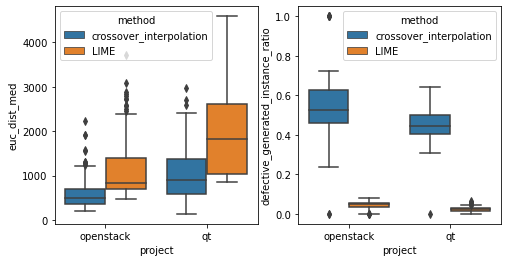

In [99]:
openstack_result_df = pd.read_csv('./eval_result/RQ1_openstack.csv')
qt_result_df = pd.read_csv('./eval_result/RQ1_qt.csv')

result_df = pd.concat([openstack_result_df, qt_result_df])
display(result_df.head())

fig, axs = plt.subplots(1,2, figsize=(8,4))

sns.boxplot(data=result_df, x='project', y='euc_dist_med', hue='method', ax=axs[0])
sns.boxplot(data=result_df, x='project', y='defective_generated_instance_ratio', hue='method', ax=axs[1])
plt.show()

In [58]:
# eval_local_model('openstack')
# rq2_eval('openstack')
# rq2_eval('qt')

/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalar

,project,commit id,method,balanced_accuracy,AUC,F1,MCC
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,crossover_interpolation,0.914181,0.971497,0.905936,0.832332
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,0.579753,0.740423,0.281192,0.268961
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,crossover_interpolation,1.000000,1.000000,1.000000,1.000000
3,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,0.580125,0.745687,0.282288,0.277408
4,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,crossover_interpolation,0.935895,0.986777,0.933446,0.874022
...,...,...,...,...,...,...,...
391,openstack,605749ca12af969ac122008b4fa14904df68caf7,LIME,0.593470,0.766139,0.316354,0.287202
392,openstack,85239cc81440d9e5a4aee3c0961c96a4197ad939,crossover_interpolation,0.953989,0.993379,0.941732,0.922158
393,openstack,85239cc81440d9e5a4aee3c0961c96a4197ad939,LIME,0.582851,0.755158,0.288425,0.278623
394,openstack,f0f52a0085a1f5bbd23e6cfa8f0ea935e8fd56c8,crossover_interpolation,0.952267,0.991391,0.946396,0.904913


finished RQ2 of openstack


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


,project,commit id,method,balanced_accuracy,AUC,F1,MCC
0,qt,f5dbc876378ae58a7bdfe1e9664fc81caca18dfb,crossover_interpolation,0.942295,0.990326,0.932782,0.886589
1,qt,f5dbc876378ae58a7bdfe1e9664fc81caca18dfb,LIME,0.545853,0.729363,0.173228,0.219584
2,qt,602bd9873786ccadcb67da3036329f3122555cf8,crossover_interpolation,0.995112,0.999913,0.994624,0.990225
3,qt,602bd9873786ccadcb67da3036329f3122555cf8,LIME,0.535057,0.707875,0.138114,0.183357
4,qt,9d75626b1073113d77988bcb52e99215d5af4787,crossover_interpolation,0.946433,0.992387,0.940270,0.895406
...,...,...,...,...,...,...,...
153,qt,9bb634a6176c639bd6b52d58151e9927c30919d0,LIME,0.506477,0.711098,0.031609,0.061353
154,qt,1e8de50674f5b33a50c45224b7e07b3f974f6ab0,crossover_interpolation,1.000000,1.000000,1.000000,1.000000
155,qt,1e8de50674f5b33a50c45224b7e07b3f974f6ab0,LIME,0.549680,0.691682,0.185366,0.240080
156,qt,979a0406f0013560efbdcc486b32ba93ce8c946f,crossover_interpolation,0.943277,0.989941,0.935515,0.889176


finished RQ2 of qt


,project,commit id,method,balanced_accuracy,AUC,F1,MCC
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,crossover_interpolation,0.914181,0.971497,0.905936,0.832332
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,0.579753,0.740423,0.281192,0.268961
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,crossover_interpolation,1.000000,1.000000,1.000000,1.000000
3,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,0.580125,0.745687,0.282288,0.277408
4,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,crossover_interpolation,0.935895,0.986777,0.933446,0.874022


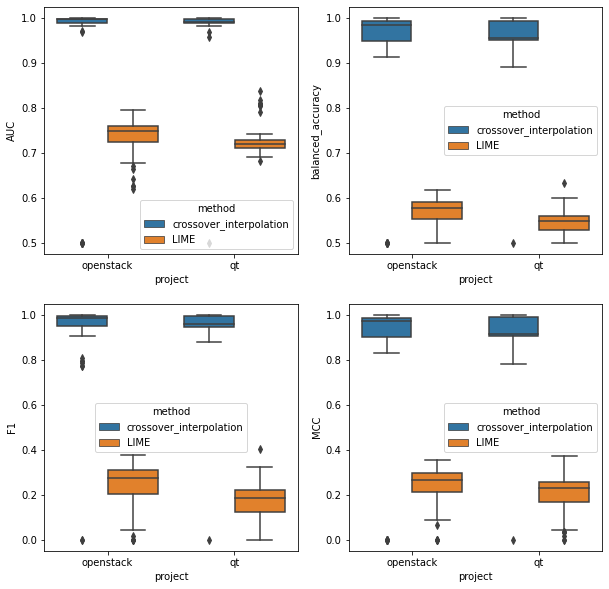

In [100]:
openstack_result_df = pd.read_csv('./eval_result/RQ2_openstack.csv')
qt_result_df = pd.read_csv('./eval_result/RQ2_qt.csv')

result_df = pd.concat([openstack_result_df, qt_result_df])
display(result_df.head())

fig, axs = plt.subplots(2,2, figsize=(10,10))

sns.boxplot(data=result_df, x='project', y='AUC', hue='method', ax=axs[0,0])
sns.boxplot(data=result_df, x='project', y='balanced_accuracy', hue='method', ax=axs[0,1])
sns.boxplot(data=result_df, x='project', y='F1', hue='method', ax=axs[1,0])
sns.boxplot(data=result_df, x='project', y='MCC', hue='method', ax=axs[1,1])

plt.show()

,project,commit id,method,rule_ratio
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,crossover_interpolation,0.920514
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,0.748158
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,crossover_interpolation,0.656716
3,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,0.748158
4,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,crossover_interpolation,0.957647


<AxesSubplot:xlabel='project', ylabel='rule_ratio'>

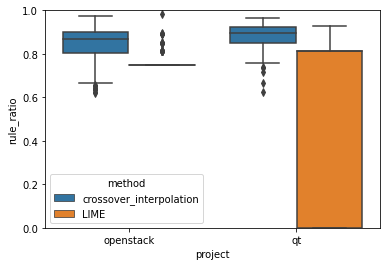

In [131]:
openstack_result_df = pd.read_csv('./eval_result/RQ3_openstack.csv')
qt_result_df = pd.read_csv('./eval_result/RQ3_qt.csv')

result_df = pd.concat([openstack_result_df, qt_result_df])
display(result_df.head())

plt.ylim(0,1)
sns.boxplot(data=result_df, x='project', y='rule_ratio', hue='method')

In [132]:
print('Count unique value of LIME in openstack')
print(Counter(list(openstack_result_df[openstack_result_df['method']=='LIME']['rule_ratio'])))
print('Count unique value of LIME in qt')
print(Counter(list(qt_result_df[qt_result_df['method']=='LIME']['rule_ratio'])))

Count unique value of LIME in openstack
Counter({0.7481577806675336: 170, 0.8127812781278128: 13, 0.8512685914260717: 9, 0.8935626307227515: 4, 0.9842814371257484: 1, 0.8943248532289628: 1})
Count unique value of LIME in qt
Counter({0.8143687707641196: 36, 0.0: 32, 0.926910916868142: 8, 0.8836206896551724: 3})


,project,commit id,method,rule_ratio
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,crossover_interpolation,0.876163
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,0.621064
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,crossover_interpolation,0.574074
3,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,0.621064
4,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,crossover_interpolation,0.929644


<AxesSubplot:xlabel='project', ylabel='rule_ratio'>

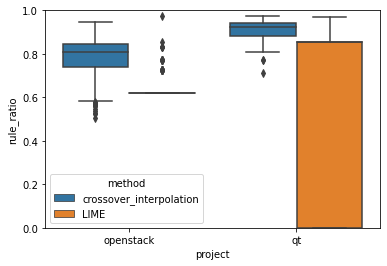

In [133]:
openstack_result_df = pd.read_csv('./eval_result/RQ4_openstack.csv')
qt_result_df = pd.read_csv('./eval_result/RQ4_qt.csv')

result_df = pd.concat([openstack_result_df, qt_result_df])
display(result_df.head())
plt.ylim(0,1)
sns.boxplot(data=result_df, x='project', y='rule_ratio', hue='method')

In [134]:
print('Count unique value of LIME in openstack')
print(Counter(list(openstack_result_df[openstack_result_df['method']=='LIME']['rule_ratio'])))
print('Count unique value of LIME in qt')
print(Counter(list(qt_result_df[qt_result_df['method']=='LIME']['rule_ratio'])))

Count unique value of LIME in openstack
Counter({0.6210640608034745: 170, 0.7274569402228976: 13, 0.7716701902748414: 9, 0.8326650628174285: 4, 0.9733700642791552: 1, 0.8533178114086146: 1})
Count unique value of LIME in qt
Counter({0.8561460010735373: 36, 0.0: 32, 0.9674556213017752: 8, 0.8777777777777778: 3})


In [108]:
x_train, x_test, y_train, y_test = prepare_data('openstack', mode = 'all')
train_df = x_train.copy()
train_df['label'] = y_train

In [109]:
display(train_df[train_df['la']>58])

,la,nd,ns,ent,nrev,rtime,self,ndev,age,app,rrexp,asawr,rsawr,label
commit_id,,,,,,,,,,,,,,
0d54770ee109bc7d598539b9238affdd1880997b,275,5,1,0.583216,3.0,1.729734,0,25.0,0.097581,2.0,272.0,0.114187,0.681661,False
5335b4ab0ef1f91203905764de6fcc7e53cb2934,288,7,2,0.648361,11.0,21.868067,0,30.0,0.116418,2.0,131.0,0.003413,0.327645,False
f3a9665e4349160fba08a09b846a773f4e785ba4,76,1,1,0.000000,5.0,-547.903623,0,11.0,1.902905,2.0,16.0,0.230769,0.307692,False
f53fb7705a48fb55de6547234a6937fc69a6e35b,1776,6,1,0.623152,6.0,-573.375440,0,2.0,16.391045,1.0,17.0,0.200000,0.550000,False
c77571e9199c756825d6805e5cb916973c010b64,272,2,1,0.154577,1.0,0.179028,0,21.0,0.798113,2.0,266.0,0.089701,0.621262,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77b23d6355d76a90610698ba06f4980c50ea84a0,72,1,1,0.000000,3.0,1.724039,0,0.0,0.000000,3.0,324.0,0.001217,0.358881,True
b0353599524121439878f10323c7482070523a39,64,5,1,0.852007,5.0,63.036285,0,33.0,16.028571,4.0,2803.0,0.000356,0.394549,False
70d1ec67c19b1e7639c8bf658cb40a65878875a1,65,2,1,0.935941,2.0,1.499549,0,4.0,44.199653,2.0,811.0,0.004860,0.889429,True
